In [1]:
import pandas  as pd
import os
import numpy as np
%matplotlib inline

In [2]:
inVcfDir='/data/cellardata/users/btsui/dbsnp/Homo_sapiens/All_20170710.f1_byte2_not_00.vcf.gz' 
vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(str)


/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [68]:
vcfDf.drop_duplicates(['Chr','Pos']).shape

(387950, 11)

In [4]:
#'\w{22}'

In [5]:
vcfDf['VP_Int']=vcfDf['Annot'].str.extract('VP=(0x\w+)',expand=False).apply(lambda Str:int(Str,16))

In [6]:
#from right to left
nth_bit=6
vcfDf['somatic']=(vcfDf['VP_Int']%(2**(nth_bit-1))).astype(bool).values

In [7]:
vcfDf['specificSNP']=vcfDf['AltBase'].str.contains('^[ACGT]$')

In [8]:
somaticI=vcfDf[vcfDf['somatic']&vcfDf['specificSNP']].set_index(['Chr','Pos','AltBase']).index

In [9]:
germline_I=vcfDf[(~vcfDf['somatic'])&vcfDf['specificSNP']].set_index(['Chr','Pos','AltBase']).index

In [10]:
#somatic_I=vcfDf.set_index('AltBase')

In [11]:
myG=['Run_db','Run_digits',u'Chr', u'Pos',u'base']
vcfDf.head()

Chr     Pos        RsId RefBase AltBase        \
0   1   14727   rs1045587       G       A  .  .   
1   1  630825   rs9783068       T       C  .  .   
2   1  630833   rs9701099       C       T  .  .   
3   1  817186   rs3094315       G       A  .  .   
4   1  833068  rs12562034       G       A  .  .   

                                               Annot  \
0  RS=1045587;RSPOS=14727;RV;dbSNPBuildID=117;SSR...   
1  RS=9783068;RSPOS=630825;dbSNPBuildID=119;SSR=1...   
2  RS=9701099;RSPOS=630833;dbSNPBuildID=119;SSR=1...   
3  RS=3094315;RSPOS=817186;RV;dbSNPBuildID=103;SS...   
4  RS=12562034;RSPOS=833068;dbSNPBuildID=120;SSR=...   

                         VP_Int  somatic  specificSNP  
0  1547614017554423799187767552    False         True  
1  1547613980660935651768664384    False         True  
2  1547613980660935651768664384    False         True  
3  1548822906480573393185800449     True         True  
4  1548823017161040034332147968    False         True

In [12]:
refI=vcfDf.set_index(['Chr','Pos','RefBase']).index

In [13]:
tmp_dir='/nrnb/users/btsui/Data/all_seq/tmp/'

In [14]:
inFnameS=pd.Series(os.listdir(tmp_dir))#.sample(n=100)

In [15]:
#!mkdir /tmp/btsui/jupyter/

In [16]:
varToPlot='pass rd'

In [17]:
myG=['ref base','base','Chr','Pos']


In [18]:
#inFname=inFnameS.iloc[1]
def inF(inFname):
    try:
        tmpDf=pd.read_pickle(tmp_dir+inFname)
    except:
        print ('failed:',inFname)
        return None
    tmpDf2=tmpDf.reset_index().drop_duplicates()



    #tmpDf2.head().dtypes

    myI=tmpDf2.set_index(['Chr','Pos','base']).index

    m_inRef=myI.isin(refI)
    m_somatic=myI.isin(somaticI)
    m_germline=myI.isin(germline_I)
    tmpDf2.loc[m_inRef,'ref base']='Reference alleles'
    tmpDf2.loc[m_somatic,'ref base']='Known somatic \nmutations'
    tmpDf2.loc[m_germline,'ref base']='Known germline \nmutations'
    #tmpDf2['ref base'].fillna('Known germline \nmutations',inplace=True)

    tmpDf2['pass rd']=tmpDf2['ReadDepth']>=2
    #myG=['ref base','base','Run_db','Run_digits']
    
    tmpS=tmpDf2.groupby(myG)[varToPlot].sum()
    tmpS.to_pickle('/tmp/btsui/jupyter/'+inFname)
    return tmpS


In [19]:
from multiprocessing import Pool

In [20]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
#tmpSL=list(tqdm(map(inF,inFnameS.values),
#                   total=len(inFnameS)))

In [ ]:
#take one hour and twenty mins
#ls_out.txt: screwed up the process
with Pool(48) as p:
    tmpSL=list(tqdm(p.imap(inF,inFnameS.values),total=len(inFnameS)))#,
                   #total=len(inFnameS))

  3%|▎         | 81/2533 [02:40<1:20:51,  1.98s/it] 

In [70]:
#tmpSL[0]

In [37]:
len(tmpSL)

2533

In [31]:
mergeS_raw=pd.concat(tmpSL,axis=0)#.groupby(myG).sum()

In [32]:
mergeS_raw=mergeS_raw.groupby(myG).sum()

In [33]:
mergedS=np.log10(mergeS_raw+1)

In [34]:
mergedS.head()

ref base                    base  Chr  Pos   
Known germline \nmutations  A     1    14727     4.880116
                                       833068    2.821514
                                       842133    2.788875
                                       948136    2.155336
                                       970788    1.863323
Name: pass rd, dtype: float64

In [35]:
#%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42


In [76]:
#mergeS_raw#.groupby('ref base')

In [78]:
mergeS_raw.groupby('ref base').quantile(0.5)

ref base
Known germline \nmutations      912.0
Known somatic \nmutations      4876.0
Reference alleles             33232.0
Name: pass rd, dtype: float64

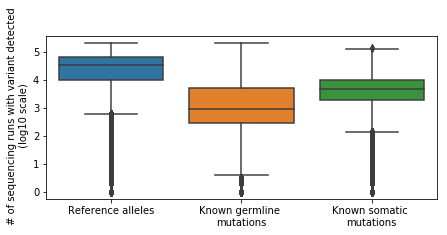

In [65]:
fig,ax=plt.subplots(figsize=(7,3))
xorder=['Reference alleles','Known germline \nmutations','Known somatic \nmutations']
ax=sns.boxplot(data=mergedS.reset_index(),
               x='ref base',y=varToPlot,ax=ax,order=xorder)
#    tmpDf2.loc[m_inRef,'ref base']='Reference alleles'
#    tmpDf2.loc[m_somatic,'ref base']='Known somatic \nmutations'
#    tmpDf2.loc[m_germline,'ref base']='Known germline \nmutations'
#ax.set_xticks()
#at least 2 reads
#each dot is a variant
#ax.set_yscale('log')
#ax.set_ylim([0,10**6])
#ax.ticklabel_format(axis='y',style='sci',scilimits=(1,4))

ax.set_ylabel(' # of sequencing runs with variant detected\n (log10 scale)' )
#ax.set_xlabel()
ax.set_xlabel('')
fig.savefig('./Figures/variant_suppport_for_each_sequencing_run.pdf')
fig.savefig('./Figures/variant_suppport_for_each_sequencing_run.png',dpi=300)

In [66]:
!echo $PWD/./Figures/variant_suppport_for_each_sequencing_run.pdf

/cellar/users/btsui/Project/METAMAP/notebook/RapMapTest/Analysis/./Figures/variant_suppport_for_each_sequencing_run.pdf


In [258]:
#ax=mergedS[False].hist()

In [60]:
### make sure the data read in will have all the results
inFname=inFnameS.iloc[1]

tmpDf=pd.read_pickle(tmp_dir+inFname)

tmpDf2=tmpDf.reset_index().drop_duplicates()



#tmpDf2.head().dtypes

myI=tmpDf2.set_index(['Chr','Pos','base']).index

m_inRef=myI.isin(refI)

tmpDf2.loc[m_inRef,'ref base']=True

tmpDf2['ref base'].fillna(False,inplace=True)

tmpDf2['pass rd']=tmpDf2['ReadDepth']>=2

tmpS=tmpDf2.groupby(['ref base','base','Run_db','Run_digits'])['pass rd'].sum()

In [1]:
#tmpS

In [161]:
import matplotlib.pyplot as plt

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


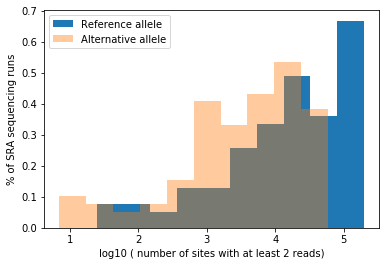

In [165]:
fig,ax=plt.subplots()
g=tmpDf2[tmpDf2['ref base']].groupby(['base','Run_db','Run_digits'])['pass rd']
countS1=np.log10(g.sum())
countS1.hist(normed=True,ax=ax,label='Reference allele')

g=tmpDf2[~tmpDf2['ref base']].groupby(['Run_db','Run_digits'])['pass rd']
countS2=np.log10(g.sum())
countS2.hist(normed=True,ax=ax,alpha=0.4,label='Alternative allele')
#'log10 ( number of sites with at least 2 reads)' , '% of SRA sequencing runs'
ax.set_ylabel('% of SRA sequencing runs')
ax.legend()
ax.set_xlabel('log10 ( number of sites with at least 2 reads)')
ax.grid(False)

In [163]:
from scipy import stats

In [ ]:
stats.wilcoxon(countS1,countS2)

In [ ]:
type(myI),

In [42]:
m_inRef.mean()

0.7398492072866819

In [ ]:
tmpDf=pd.read_pickle(tmp_dir+inFnameS.iloc[0])

In [150]:
tmpDf

features                            ReadDepth  AverageBaseQuality
Run_db Run_digits Chr Pos     base                               
ERR    18506      1   14727   A             2                  15
                              G             2                  27
                      630825  G             2                  13
                              T           165                  33
                      630833  C           180                  33
                              G             1                   7
                      842133  A             1                   7
                              G             1                  33
                      843942  A             2                  31
                      850609  C             2                  33
                      970788  G             1                  38
                      1014143 C             3                  30
                      1014228 G             2                  22
                      1014316 C             1                  28
                      1014359 G             2                  38
                      1022188 A             1                  33
                      1022225 G             1                  18
                      1022260 C             1                  22
                      1041582 G             1                  10
                      1041583 A             1                   6
                      1043476 G             1                  30
                      1044134 G             1                  11
                      1044176 G             1                  29
                      1044455 G             1                  35
                      1045172 G             1                  12
                      1045177 G             1                   6
                      1045393 C             1                  14
                      1045707 G             1                  28
                      1045751 A             1                  36
                      1045785 G             1                  39
...                                       ...                 ...
SRR    5981338    MT  15784   T          3786                  37
                      15812   A             4                  16
                              C             1                   2
                              G          3138                  37
                              T             1                   2
                      15833   A             2                   5
                              C          2133                  37
                      15848   A          1446                  37
                              G             1                   7
                              T             3                  28
                      15884   G           236                  34
                      15890   A            93                  34
                              C             8                  37
                      15923   A             1                  36
                      15927   G             1                  36
                      15928   G             1                  37
                      15932   T             1                  37
                      15943   T             3                  39
                      15950   G             3                  40
                              T             1                  34
                      15965   A             6                  39
                      15967   G             6                  39
                      15990   C            31                  36
                      16188   A             1                   2
                              C           194                  26
                      16278   C           280                  37
                      16390   C             1                   2
                              G         